   country  age  new_user  source  total_pages_visited  converted
0    China   22         1  Direct                    2          0
1       UK   21         1     Ads                    3          0
2  Germany   20         0     Seo                   14          1
3       US   23         1     Seo                    3          0
4       US   28         1  Direct                    3          0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              284580 non-null  object
 1   age                  284580 non-null  int64 
 2   new_user             284580 non-null  int64 
 3   source               284580 non-null  object
 4   total_pages_visited  284580 non-null  int64 
 5   converted            284580 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.0+ MB
       country            age       new_use

C:\Users\serda\AppData\Local\Temp\ipykernel_30952\2194779151.py:44: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()['converted'].drop('converted')


Best parameters found:  {'C': 0.1}
Highest F1 score found:  0.7660949996497063
Confusion matrix for Logistic Regression on train set:


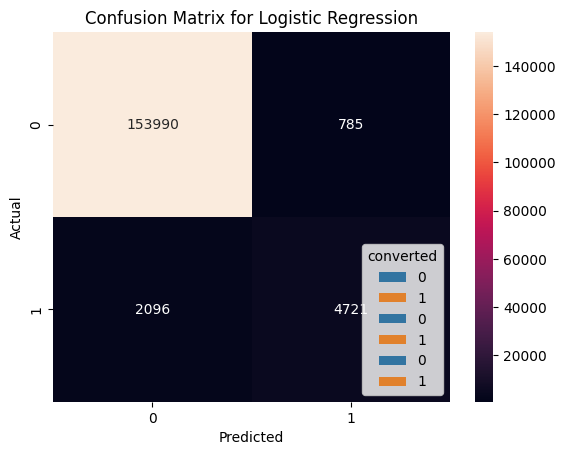

Confusion matrix for Logistic Regression on test set:


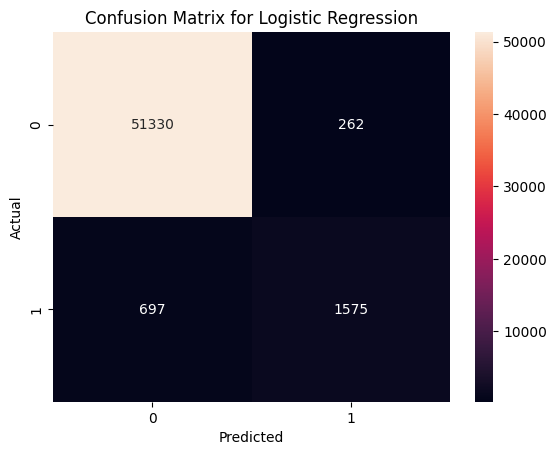

Confusion matrix for Random Forest on train set:


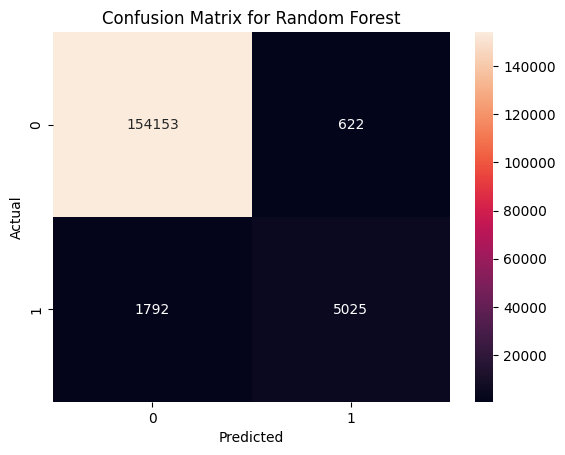

Confusion matrix for Random Forest on test set:


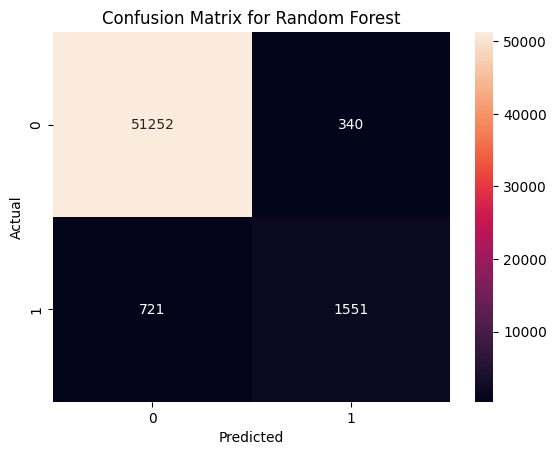

Confusion matrix for Gradient Boosting on train set:


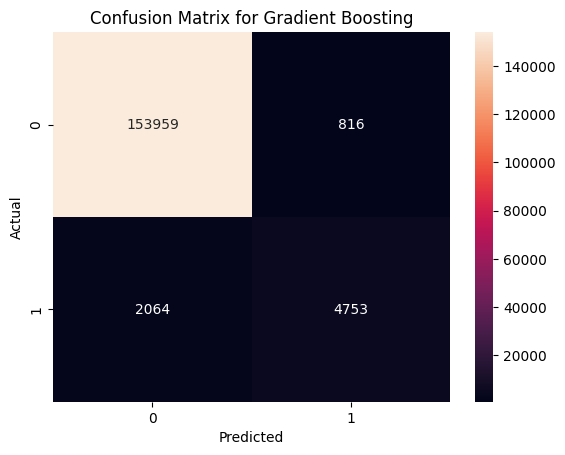

Confusion matrix for Gradient Boosting on test set:


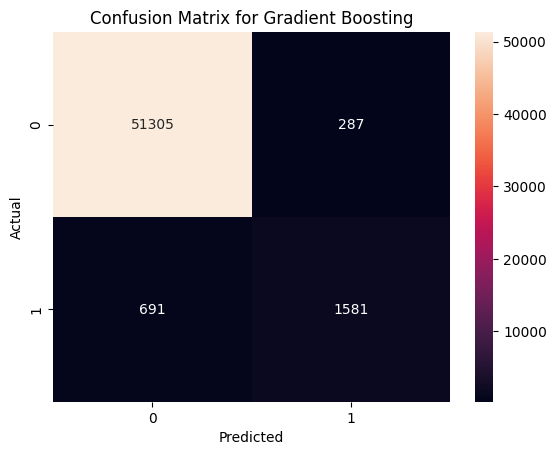

                 model  f1_train   f1_test
0  Logistic Regression  0.766210  0.766610
1        Random Forest  0.806322  0.745136
2    Gradient Boosting  0.767479  0.763768


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df=pd.read_csv('C:/Users/serda/OneDrive/Bureau/Online Education/Certification/Conversion Rate/conversion_data_train.csv')


print(df.head())

df.info()

print(df.describe(include='all'))

#EDA

sns.countplot(data=df, x='converted')
plt.savefig('converted.png')

converted_percent= (df.converted==1).sum()/len(df)*100
print(f"Conversion Percentage: {converted_percent}")

sns.countplot(data=df, x='country', hue='converted')
plt.savefig('country.png')

(df[['country']]=='China').value_counts()

china_percentage= (df.groupby('converted')['country'].value_counts()[1][3])/((df.converted==1).sum())*100
print(f"Conversion Percentage for China: {china_percentage}")

sns.countplot(data=df, x='source', hue='converted')
plt.savefig('source.png')

age_bins = pd.cut(df['age'], bins=[0, 20, 30, 40, 50, 60, 70, 80, 90, 100])
sns.countplot(x=age_bins, hue='converted', data=df)
plt.savefig('age.png')

# Correlation
corr = df.corr()['converted'].drop('converted')
sns.barplot(x=corr.index, y=corr.values)
plt.xlabel('Variables')
plt.ylabel('Correlation')
plt.title('Correlation with Converted')
plt.savefig('corr_converted.png')

df = df[df['age'] <= 80] # Remove age outliers
df = df[df['age'] >= 11]
df = df[df['country']!='China'] # Remove 'China'

# Get Dummies
df = pd.get_dummies(df, columns=['country', 'source'], drop_first=True)

# Preparing the data for the models
X=df.drop('converted', axis=1)
y=df['converted']
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.25, random_state=101, stratify=y)

# Scaling the data
scaler=StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



# Define function to plot confusion matrices
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.savefig(f'{model_name}_confusion_matrix.png')  
    plt.show()


# Define hyperparameters for Logistic Regression
C_values = np.logspace(-3, 3, 7)
param_grid = {'C': C_values}

# Apply GridSearchCV with LogisticRegression
logreg = LogisticRegression()
grid = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)

# Print best parameters and highest score
print("Best parameters found: ", grid.best_params_)
print("Highest F1 score found: ", grid.best_score_)

# Initialize the classifiers with best C for Logistic Regression
models = {
    "Logistic Regression": LogisticRegression(C=grid.best_params_['C']),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

# Initialize a dictionary to hold the f1 scores
f1_scores = {
    "model": [],
    "f1_train": [],
    "f1_test": []
}

# Train each model, get the f1 scores and confusion matrices
for model_name in models:
    model = models[model_name]
    
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Compute f1 scores and add them to the dictionary
    f1_train = f1_score(y_train, y_train_pred)
    f1_test = f1_score(y_test, y_test_pred)
    f1_scores["model"].append(model_name)
    f1_scores["f1_train"].append(f1_train)
    f1_scores["f1_test"].append(f1_test)

    # Print and plot confusion matrices
    print(f'Confusion matrix for {model_name} on train set:')
    plot_confusion_matrix(y_train, y_train_pred, model_name)
    print(f'Confusion matrix for {model_name} on test set:')
    plot_confusion_matrix(y_test, y_test_pred, model_name)

# Convert the scores to a DataFrame for a clean display
df_scores = pd.DataFrame(f1_scores)

# Display the DataFrame
print(df_scores)

In [4]:


X = np.concatenate([X_train, X_test], axis=0)
y = np.concatenate([y_train, y_test])

# Instantiate Logistic Regression model with the best parameters and fit it to all data
best_logreg = LogisticRegression(C=grid.best_params_['C'])
best_logreg.fit(X, y)

# Load data without labels
data_without_labels = pd.read_csv('C:/Users/serda/OneDrive/Bureau/Online Education/Certification/Conversion Rate/conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# One-hot encoding for categorical variables
X_without_labels = pd.get_dummies(data_without_labels, columns=['country', 'source'], drop_first=True)

# Convert pandas DataFrame to numpy array before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_without_labels = X_without_labels.values
print("...Done")

print(X_without_labels[0:5, :])

# Scale the data without labels using the same scaler used for training data
X_without_labels = scaler.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5, :])

# Make predictions on data without labels
all_data_pred = best_logreg.predict(X_without_labels)

data = {
    'converted': all_data_pred
}

# Create a dataframe for the predictions and save it to a csv file
Y_predictions = pd.DataFrame(columns=['converted'], data=data)
Y_predictions.to_csv('conversion_data_test_predictions_SERDAR_model_3.csv', index=False)


Prediction set (without labels) : (31620, 5)
Convert pandas DataFrames to numpy arrays...
...Done
[[28  0 16  0  1  0  0  1]
 [22  1  5  0  1  0  1  0]
 [32  1  1  0  0  0  0  1]
 [32  1  6  0  0  1  0  0]
 [25  0  3  0  0  0  0  1]]
...Done
[[-0.31201456 -1.48107222  3.33192104 -0.2065242   2.34583465 -1.13357977
  -0.54436949  1.02022481]
 [-1.03782904  0.67518652  0.0378353  -0.2065242   2.34583465 -1.13357977
   1.83698761 -0.98017612]
 [ 0.17186176  0.67518652 -1.16001406 -0.2065242  -0.42628751 -1.13357977
  -0.54436949  1.02022481]
 [ 0.17186176  0.67518652  0.33729764 -0.2065242  -0.42628751  0.88216112
  -0.54436949 -0.98017612]
 [-0.6749218  -1.48107222 -0.56108938 -0.2065242  -0.42628751 -1.13357977
  -0.54436949  1.02022481]]
